<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [4.5 Machine Learning](https://jckantor.github.io/cbe30338-2021/04.05-Machine-Learning.html) | [Contents](toc.html) | [5.0 Optimization](https://jckantor.github.io/cbe30338-2021/05.00-Optimization.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.06-Lab-Assignment-Anomaly-Detection.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.06-Lab-Assignment-Anomaly-Detection.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.6 Lab Assignment: Anomaly Detection

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy

from tclab import setup, Historian, Plotter, clock

## 4.6.1 State Space Model

The state-space model for the Temperature Control Laboratory is given by 

\begin{align}
\frac{d}{dt}\underbrace{\left[\begin{array}{c} T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2} \end{array}\right]}_x
& = 
\underbrace{\left[\begin{array}{cccc}
-(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} & \frac{U_c}{C^H_p} & 0 \\
\frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} & 0 & 0 \\
\frac{U_c}{C^H_p} & 0 & -(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} \\
0 & 0 & \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p}
\end{array}\right]}_A
\underbrace{\left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]}_x
+
\underbrace{\left[\begin{array}{cc}\frac{\alpha P_1}{C_p} & 0 \\ 0 & 0 \\ 0 & \frac{\alpha P_2}{C_p} \\ 0 & 0 \end{array}\right]}_{B_u}
\underbrace{\left[\begin{array}{c}u_1 \\ u_2\end{array}\right]}_u
+
\underbrace{\left[\begin{array}{c}\frac{U_a}{C^H_p} \\ 0 \\ \frac{U_a}{C^H_p} \\ 0 \end{array}\right]}_{B_d}
\underbrace{\left[\begin{array}{c}T_{amb}\end{array}\right]}_{d}
\end{align}

\begin{align}
\underbrace{\left[\begin{array}{c} T_1 \\ T_2 \end{array}\right]}_y
& = 
\underbrace{\left[\begin{array}{cccc} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{array}\right]}_C
\underbrace{\left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]}_x
\end{align}

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]
\qquad
u = \left[\begin{array}{c}u_1 \\ u_2\end{array}\right]
\qquad
d = \left[\begin{array}{c}T_{amb}\end{array}\right]
\qquad
y = \left[\begin{array}{c} T_1 \\ T_2 \end{array}\right]
$$

$$
A = \left[\begin{array}{cccc}
-(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} & \frac{U_c}{C^H_p} & 0 \\
\frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} & 0 & 0 \\
\frac{U_c}{C^H_p} & 0 & -(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} \\
0 & 0 & \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p}
\end{array}\right]
\qquad
B_u = \left[\begin{array}{cc}\frac{\alpha P_1}{C_p} & 0 \\ 0 & 0 \\ 0 & \frac{\alpha P_2}{C_p} \\ 0 & 0 \end{array}\right]
\qquad
B_d  = \left[\begin{array}{c}\frac{U_a}{C^H_p} \\ 0 \\ \frac{U_a}{C^H_p} \\ 0 \end{array}\right]
\qquad
C = \left[\begin{array}{cccc} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{array}\right]
$$

In [38]:
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
CpH = 4.46            # heat capacity of the heater (J/deg C)
CpS = 0.819           # heat capacity of the sensor (J/deg C)
Ua = 0.050            # heat transfer coefficient from heater to environment
Ub = 0.021            # heat transfer coefficient from heater to sensor
Uc = 0.0335           # heat transfer coefficient between heaters
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

## 4.6.2 Eigenvalues and Eigenvectors

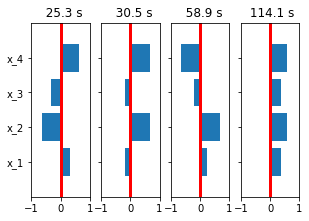

In [39]:
eigenvalues, eigenvectors = np.linalg.eig(A)
eigenmodes = [mode for mode in sorted(zip(eigenvalues, eigenvectors.T))]
n = len(eigenmodes)
fig, ax = plt.subplots(1, n, figsize=(1.2*n, 0.8*n), sharey=True)
for k, mode in enumerate(sorted(eigenmodes)):
    eval, evec = mode
    evec = evec/max(evec, key=abs)
    evec = evec/np.linalg.norm(evec)
    ax[k].barh(range(n), evec)
    ax[k].set_yticks(range(n))
    ax[k].set_yticklabels([f"x_{k}" for k in range(1, n+1)])
    ax[k].set_xlim(-1, 1)
    ax[k].plot([0, 0], [-1, n], 'r', lw=3)
    ax[k].set_ylim(-1, n)
    
    ax[k].set_title(f"{-1/eval: 6.1f} s")

## 4.6.3 Observer

At each time step $t_k$ there are two calculations to perform:

* **Model Prediction:** Use the model to update the state to the next time step, i.e., $\hat{x}_{k-1} \rightarrow \hat{x}_{k}^{pred}$ with the equation

\begin{align}
\hat{x}_k^{pred} & = \hat{x}_{k-1} + (t_k - t_{k-1}) ( A \hat{x}_{k-1} + B_u u_{k-1} + B_d \hat{d}_{k-1}) \\
\hat{y}_k^{pred} & = C \hat{x}_k^{pred}
\end{align}

* **Measurement Correction:** Use measurement $y_k$ to update $\hat{x}_{k}^{pred} \rightarrow \hat{x}_{k}$ with the equation

$$\hat{x}_{k} = \hat{x}_{k}^{pred} - (t_k - t_{k-1})L (\underbrace{\hat{y}_{k}^{pred} - y_k}_{y_k^{err}})$$ 

The following cell presents an implementation of an observer for the Temperaaature Control Lab. This implementation uses `copy.deepcopy()` to allow multiple instances of this observer to be created with independent values of `x_hat`.

In [96]:
# assume A, Bu, Bd, and C for a state space model have been defined

def tclab_observer(L, x_initial, d_hat):
    
    # initialize
    x_hat = x_initial
    t = 0
    y_err = None

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state, wait for message to get
        # t : next time value
        # u : value of manipulated variables from t_prev to t
        # y : measured value of process variables at time t
        t, u, y = yield x_hat, y_err
        
        # model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A, x_hat) + np.dot(Bu, u) + np.dot(Bd, d_hat))
        y_pred = np.dot(C, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L, y_err)

## 4.6.4 Testing the Observer

In [97]:
def experiment(observer, u1, u2, t_final=400, t_step=2):
    
    # open connection to tclab
    TCLab = setup(connected=False, speedup=20)
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1, lab.T2]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

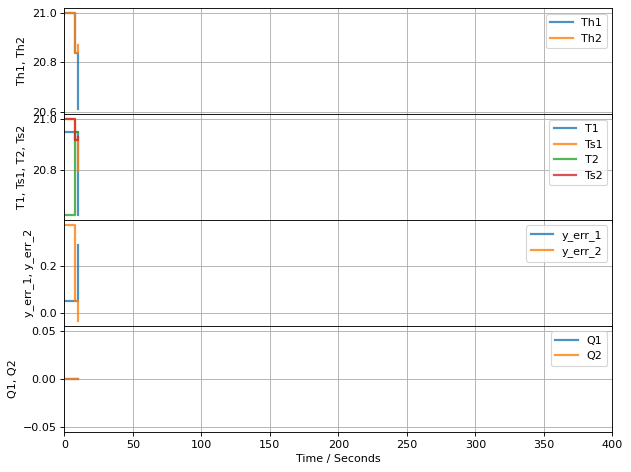

TCLab Model disconnected successfully.


KeyboardInterrupt: 

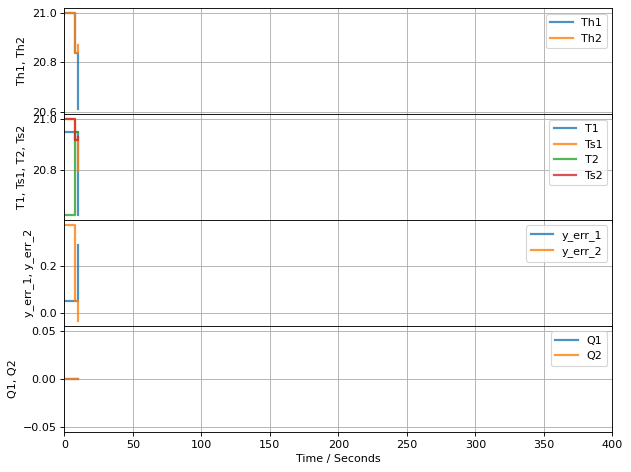

In [98]:
def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])
observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

## 4.6.5 Determining L

In [76]:
evals, _ = np.linalg.eig(A - L @ C)
-1/evals

array([10.93466291-0.j        ,  7.49479412+1.49938629j,
        7.49479412-1.49938629j,  6.66186946-0.j        ])

In [99]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)
results = place_poles(A.T, C.T, 10*evals)
L = results.gain_matrix.T
print(L)

[[1.52654684 0.79594899]
 [0.44829383 0.0809427 ]
 [0.82498918 1.42134734]
 [0.08368953 0.43499351]]


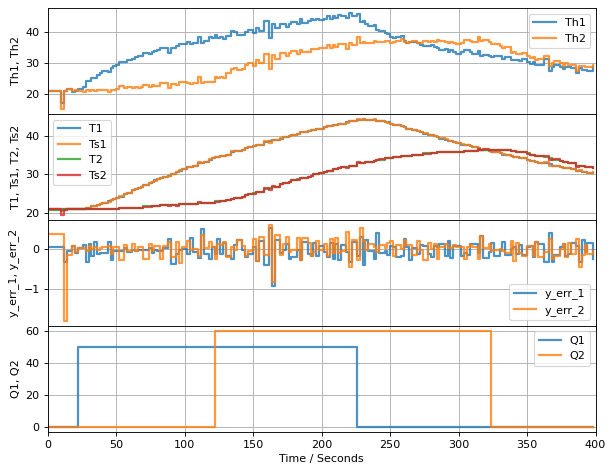

TCLab Model disconnected successfully.


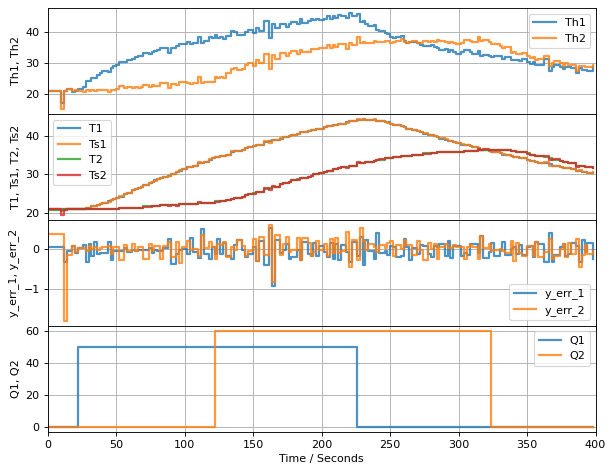

In [95]:

def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

## 4.6.6 Exercise 1.

Tune L for your device.


## 4.6.7 Disturbance estimator



In [121]:
A_ = np.vstack([np.hstack([A, Bd]), np.zeros([1, 5])])
B_ = np.vstack([Bu, [[0, 0]]])
C_ = np.hstack([C, np.zeros([2, 1])])

evals, _ = np.linalg.eig(A_)
print(3*evals)
results = place_poles(A_.T, C_.T, [-0.03, -0.05, -0.11, -0.10, -0.12])
L = results.gain_matrix.T
print()
print(L)

[-0.02629557 -0.05096539 -0.1187828  -0.09838535  0.        ]

[[0.32443289 0.26038698]
 [0.1559942  0.05245965]
 [0.26092143 0.32381657]
 [0.05256272 0.15586276]
 [0.62691905 0.62544879]]


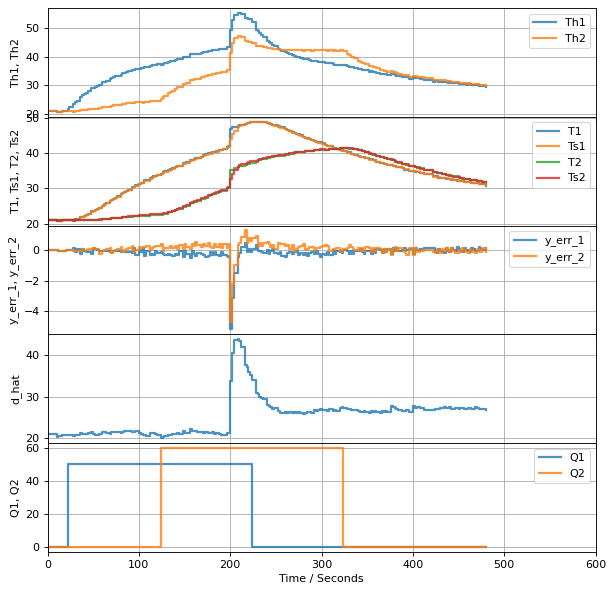

TCLab Model disconnected successfully.


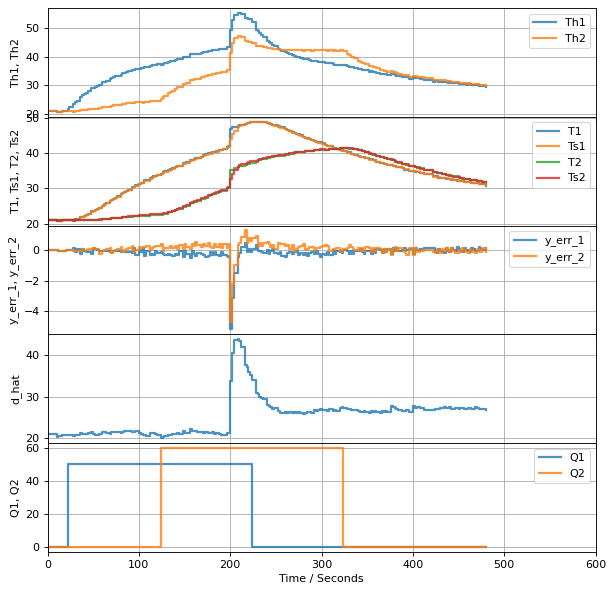

In [124]:

def tclab_observer_disturbance(L, x_initial, d_hat):
    
    # initialize
    x_hat = np.hstack([x_initial, d_hat])
    print(x_hat)
    t = 0
    y_err = None
    
    A_ = np.vstack([np.hstack([A, Bd]), np.zeros([1, 5])])
    B_ = np.vstack([Bu, [[0, 0]]])
    C_ = np.hstack([C, np.zeros([2, 1])])

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state, wait for message to get
        # t : next time value
        # u : value of manipulated variables from t_prev to t
        # y : measured value of process variables at time t
        t, u, y = yield x_hat, y_err
        
        # model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A_, x_hat) + np.dot(B_, u))
        y_pred = np.dot(C_, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L, y_err)
                       
                       
def experiment_disturbance(observer, u1, u2, t_final=400, t_step=2):
    
    # open connection to tclab
    TCLab = setup(connected=False, speedup=20)
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('d_hat', lambda: x[4]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['d_hat'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1 + d(t), lab.T2 + d(t)]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

def d(t):
    return 0 if t <= 200 else 5

experiment_disturbance(tclab_observer_disturbance(L, x_initial, d_initial), u1, u2, t_final=600)

<!--NAVIGATION-->
< [4.5 Machine Learning](https://jckantor.github.io/cbe30338-2021/04.05-Machine-Learning.html) | [Contents](toc.html) | [5.0 Optimization](https://jckantor.github.io/cbe30338-2021/05.00-Optimization.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.06-Lab-Assignment-Anomaly-Detection.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.06-Lab-Assignment-Anomaly-Detection.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>